# Proyecto 1-Etapa 1-Clasificacion
**Integrantes del grupo:**

*   Nicolás Ballén Barajas-202310273
*   Carlos Alberto Poveda Riaño-202315546
*   Edward Camilo Sánchez Novoa-202113020

El siguiente notebook servirá como informe preliminar de la primera etapa de nuestro proyecto 1, dentro del cual, mediante el preprocesamiento de texto, clasificaremos opiniones en tres diferentes categorías. Este se dividirá de la siguiente forma:

- Seccion 1: Documentación de Aprendizaje Automático
- Seccion 2: Entendimiento y Preparación de Datos
- Seccion 3: Construcción y evaluacion de modelos
- Seccion 4: Revisión de Resultados

## Caso
Uno de los mayores desafíos en este proceso es el análisis de información textual  proveniente de distintas fuentes vinculadas a la planificación participativa territorial. Esta  tarea demanda recursos significativos y expertos capaces de relacionar los contenidos con  los ODS. Contar con este conocimiento permitiría tomar decisiones más informadas basadas  en la opinión ciudadana, orientando las políticas públicas hacia el cumplimiento de la Agenda 2030

El UNFPA busca desarrollar un proyecto conjunto con ustedes, cuyo objetivo principal es  vincular de forma automática las opiniones de la ciudadanía con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4 (Fin de la Pobreza, Salud y Bienestar, y Educacion de Calidad). Para ello, se deberá aplicar una metodología de desarrollo de aplicaciones analíticas que permita crear un modelo capaz de analizar y clasificar dichas  opiniones. Este modelo deberá integrarse en una aplicación web o móvil, desde la cual  podrá ser utilizado y reentrenado continuamente a partir de textos en lenguaje natural.

## Seccion 1: Documentacion de Aprendizaje Automático

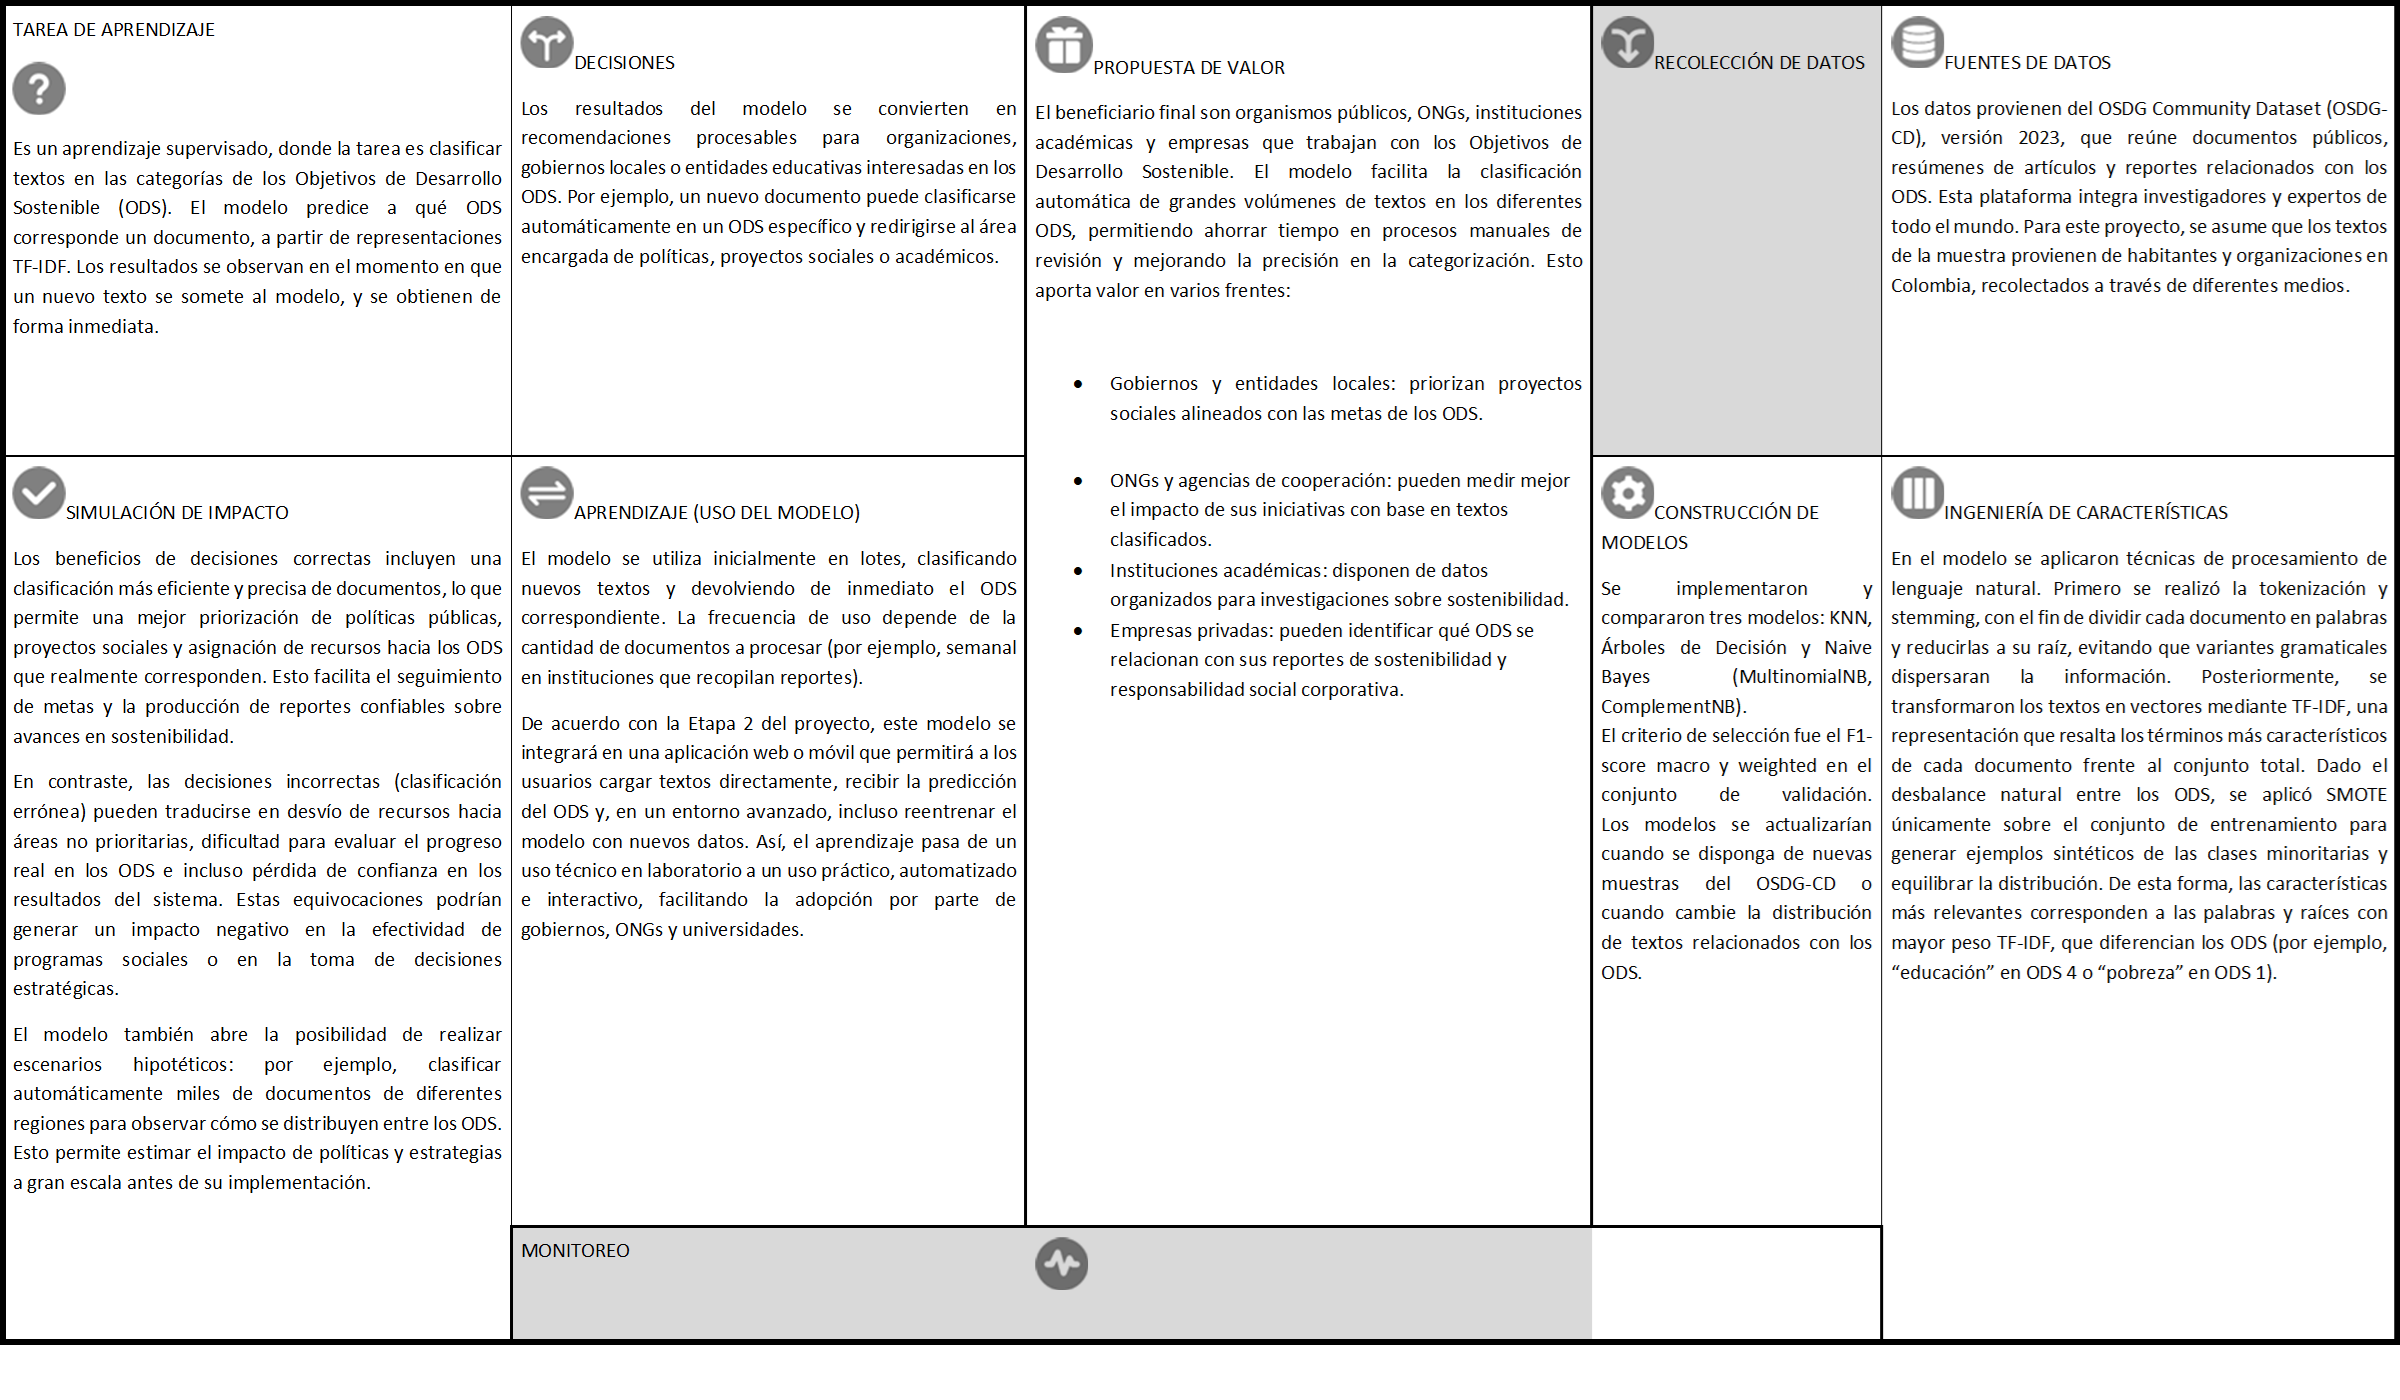

## Seccion 2: Entendimiento y Preparación de Datos

### Carga de Datos

In [3]:
# Importamos pandas para manejar el dataset
import pandas as pd
#Importamos matplotlib para graficacion con numeracion asistida por numpy
import matplotlib.pyplot as plt
import numpy as np
#NLTK para tokenizacion de palabras
import nltk


In [4]:
#Carga de datos:
loc_entrenamiento="Datos_proyecto.xlsx"
loc_validacion="Datos de prueba_proyecto.xlsx"

train_bd=pd.read_excel(loc_entrenamiento)
val_bd=pd.read_excel(loc_validacion)

display(train_bd)
display(val_bd)

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1
2422,"Sin embargo, estas fallas del mercado implican...",3


,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."
...,...
147,"En Croacia, Grecia y Rumanía, 1 de cada 3 niño..."
148,El informe también es una adición oportuna a l...
149,"Además, de los 1200 millones que salieron de l..."
150,Aunque el porcentaje de población en situación...


In [5]:
#Revision tipos de datos:
print("Resumen de los datos de entrenamiento: \n")
display(train_bd.info())
print("\nResumen de los datos de prueba: \n")
display(val_bd.info())

Resumen de los datos de entrenamiento: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None


Resumen de los datos de prueba: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  152 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


None

En un principio, vemos que tenemos 2424 registros completos de texto y labels/etiquetas en entrenamiento, al mismo tiempo que textos en español en los datos de prueba. Para facilitar el manejo mas adelante, cambiamos el tipo de datos de los textos de objeto a texto.

In [6]:
#Conversion a texto
def obj_texto(db):
  variables=db.select_dtypes(include=['object']).columns.to_list()
  for variable in variables:
    db[variable]=db[variable].astype('string')
obj_texto(train_bd)
obj_texto(val_bd)

Adicionalmente sabemos que las transformaciones y modelos mas adelante se guíaran por un mismo tipo de variables. Para evitar confusiones, homologamos la columna de Textos_español de prueba por textos como en los de entrenamiento.

In [7]:
#Homologacion de columna de validacion a columna de textos
val_bd["textos"]=val_bd["Textos_espanol"]
val_bd.drop("Textos_espanol", axis=1, inplace=True)
val_bd

,textos
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."
...,...
147,"En Croacia, Grecia y Rumanía, 1 de cada 3 niño..."
148,El informe también es una adición oportuna a l...
149,"Además, de los 1200 millones que salieron de l..."
150,Aunque el porcentaje de población en situación...


### Entendimiento

#### Perfilamiento

Dado que contamos en un principio con una unica variable explicativa, decidimos revisar las características de esta, siendo de un texto la longitud del mismo en caracteres y su número de palabras.

In [8]:
#Revision longitudes
train_bd["Longitud"]=train_bd["textos"].str.len()
display(train_bd['Longitud'].describe().T)
#Revision num de palabras
def num_pal(texto):
  return len(texto.split(" "))
train_bd["#_palabras"]=train_bd["textos"].apply(num_pal)
display(train_bd['#_palabras'].describe().T)

,Longitud
count,2424.0
mean,683.223185
std,223.563695
min,303.0
25%,513.0
50%,647.0
75%,809.25
max,1492.0


,#_palabras
count,2424.000000
mean,107.953795
std,35.578358
min,41.000000
25%,81.000000
50%,102.000000
75%,129.000000
max,260.000000


En primer lugar, notamos que, ignorando los labels (que sabemos son 1, 3 o 4, siendo esta la variable objetivo), ambos sets de datos tienen textos que por el enunciado sabemos representan opiniones sobre objetivos de desarrollo sostenibles, variando entre 303 y 1492 caracteres de longitud, así como de 41 a 260 palabras.

A continuación, veremos a mas detalles las distribuciones de estas últimas dos medidas, vistas desde cada categoría en los datos de entrenamiento. Esto con la intencion de identificar posibles sesgos o desbalances en los textos mismos entre las diferentes clases.

,mean,min,max
labels,,,
1,680.588119,313,1492
3,680.991051,303,1486
4,686.468293,304,1452


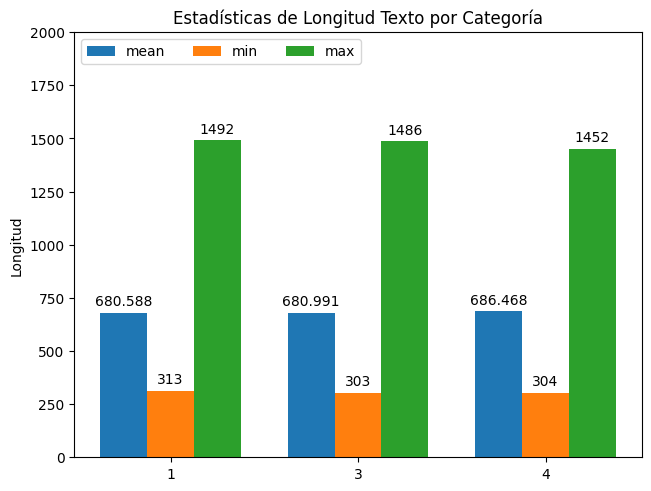

In [9]:
# Graficación de longitudes por categoría en entrenamiento
texto_label=train_bd.groupby('labels')['Longitud'].agg(['mean', 'min', 'max'])
display(texto_label)

categorias=texto_label.index.to_list()

fig, ax = plt.subplots(layout='constrained')
x=np.arange(len(categorias))
width=0.25
paso=0
for medida in texto_label.columns.to_list():
  offset = width * paso
  barra = ax.bar(x + offset, texto_label[medida], width, label=medida)
  ax.bar_label(barra, padding=3)
  paso+=1

ax.set_ylabel('Longitud')
ax.set_title('Estadísticas de Longitud Texto por Categoría')
ax.set_xticks(x + width, categorias)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 2000)

plt.show()

,mean,min,max
labels,,,
1,110.403960,41,242
3,108.064877,44,238
4,106.649756,48,260



Total de palabras: 261680



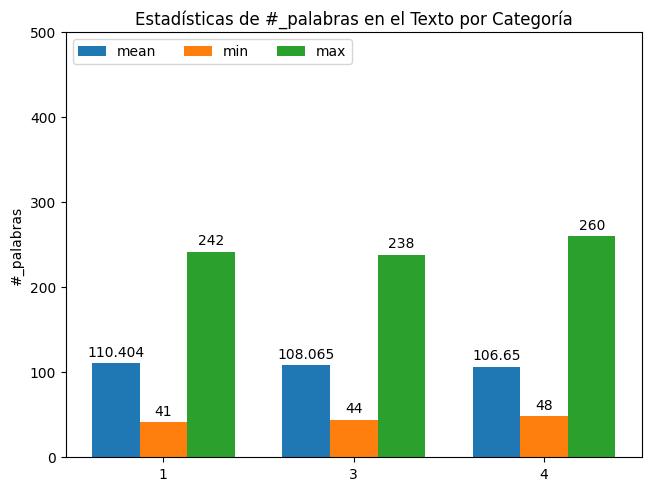

In [10]:
# Graficación de longitudes por categoría en entrenamiento
texto_label=train_bd.groupby('labels')['#_palabras'].agg(['mean', 'min', 'max'])
display(texto_label)
total_palabras=train_bd['#_palabras'].sum()
print(f"\nTotal de palabras: {total_palabras}\n")

categorias=texto_label.index.to_list()

fig, ax = plt.subplots(layout='constrained')
x=np.arange(len(categorias))
width=0.25
paso=0
for medida in texto_label.columns.to_list():
  offset = width * paso
  barra = ax.bar(x + offset, texto_label[medida], width, label=medida)
  ax.bar_label(barra, padding=3)
  paso+=1

ax.set_ylabel('#_palabras')
ax.set_title('Estadísticas de #_palabras en el Texto por Categoría')
ax.set_xticks(x + width, categorias)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 500)

plt.show()

Como pudimos ver en las gráficas anteriores, si bien no son exactas, todas las estadísticas de longitud y número de palabras son extremadamente similares entre las tres categorías. No habremos de temer un exceso o falta de palabras que pudiera favorecer o desfavorecer a una categoría en específic.

Ahora bien, algo que si nos preocupa es un posible desbalance en los datos, siendo que no sabemos si hay una categoría con mas o menos registros que las demás, resultando en un sesgo hacia la categoría con más registros. Para ello hicimos un conteo con el que corroborar los registros por categoría en los datos de entrenamiento.

,textos
labels,
1,505
3,894
4,1025


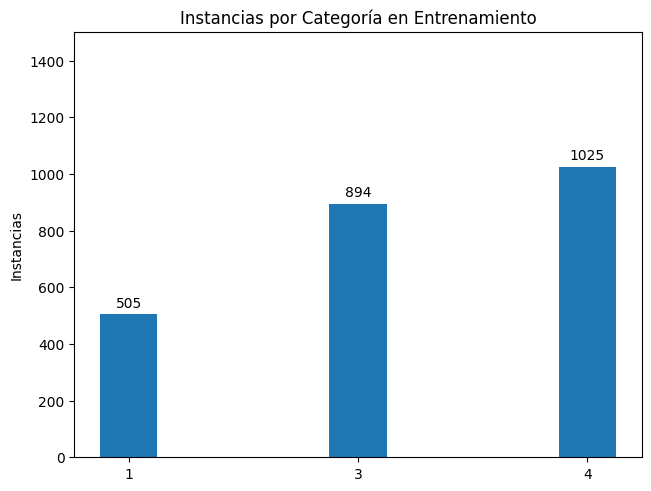

In [11]:
#Conteos por categoría
# Graficación de conteo de registros por categoría en entrenamiento
texto_label=train_bd.groupby('labels')["textos"].count()
display(texto_label)

categorias=texto_label.index.to_list()

fig, ax = plt.subplots(layout='constrained')
x=np.arange(len(categorias))
barra = ax.bar(x, texto_label, width, label=medida)
ax.bar_label(barra, padding=3)
paso+=1

ax.set_ylabel('Instancias')
ax.set_title('Instancias por Categoría en Entrenamiento')
ax.set_xticks(x, categorias)
ax.set_ylim(0, 1500)

plt.show()

Efectivamente, como temíamos, la categoría 1 de los ODS tienen menos de la mitad que la categoría 4, con la categoría 3 de por medio. Esto resultará en un desbalance de datos a favor de la categoría 4, por lo que más adelante, durante la preparación, habremos de corregirlo ante de entrenar cualquier modelo.

#### Análisis de Calidad

In [12]:
#Completitud
vacios=train_bd.isnull().sum()
print("Registro de vacíos en datos de entrenamiento\n")
display(vacios[["textos", "labels"]])
vacios_val=val_bd.isnull().sum()
print("Registro de vacíos en datos de validacion\n")
display(vacios_val)

Registro de vacíos en datos de entrenamiento



,0
textos,0
labels,0


Registro de vacíos en datos de validacion



,0
textos,0


No se presentaron vacíos en los datos de entrenamiento, ni en los de prueba.
Vemos entonces que en ambos casos hay un cumplimiento total de la completitud.

In [13]:
#Unicidad

duplicados_totales=train_bd.duplicated(subset=["textos", "labels"]).sum()
print(f"Filas duplicadas exactas en entrenamiento: {duplicados_totales}")

duplicados_totales_val=val_bd.duplicated(subset=["textos"]).sum()
print(f"Filas duplicadas exactas en validacion: {duplicados_totales_val}")

#Parciales (Entiendo parcial unicamente en el caso de entrenamiento, siendo únicamente con respecto al texto)
dup_parciales_ent=train_bd.duplicated(subset=["textos"]).sum()
print(f"Filas duplicadas parcialmente en entrenamiento: {dup_parciales_ent}")
#No hay mas columnas
dup_parciales_val=duplicados_totales_val
print(f"Filas duplicadas parcialmente en validacion: {dup_parciales_val}")

Filas duplicadas exactas en entrenamiento: 0
Filas duplicadas exactas en validacion: 0
Filas duplicadas parcialmente en entrenamiento: 0
Filas duplicadas parcialmente en validacion: 0


Nuevamente, no se identificaron duplicados en ningun set de datos de ningun tipo, por lo que ya hay un cumplimiento total de la unicidad

In [14]:
#Validez

La única invalidez que podemos identificar dadas las llaves que hay dentro de los sets de datos sería la presencia de una categoría diferente a 1, 3 o 4, siendo esta la única aclaración por parte del enunciado en cuanto a los valores ha tener en una variable (lo cual corroboramos con los conteos por categoría anteriormente, con este identificando unicamente estas 3 categorías al momento de agrupar y contar los registros).

Es decir, no hay restricciones o delimitaciones en el texto más alla de ser un texto, por lo que no tenemos razón alguna para identificar invalideces.

In [15]:
#Consistencia

Nuevamente, la unica inconsistencia que podríamos ver dadas las dos variables que tenemos sería tener registros duplicados con valores diferentes de categoría. Sin embargo, como se vio en la verificación de unicidad, no existen duplicados, por lo que no identificamos inconsistencias en este punto.

### Preparación de Datos

Con tal de convertir los datos de texto a una representación numérica, tal que estos puedan ser procesados por los algoritmos de clasificación que usaremos más adelante, usaremos el modelo **Bag of Words** o bolsa de palabras visto en claso, partiendo de la variación con la Matriz TF-IDF (ajustandonos a la tendencia en lo que preración de textos refieron).

Para seguir con esta estrategía, primero identificaremos las palabras más importantes o relevantes dentro de la totalidad de los textos, lo que implicará una identificación y limpieza de las palabras menos relevantes con tal de terminar unicamente con las más relevantes.

#### Tokenización de los textos

Para empezar, tokenizaremos los textos de cada registro en listas de palabras minúsculas, descartando las denominadas "stopwords", es decir, palabras como artículos, preposiciones, entre otras elementos gramaticales que no contienen valor semántico alguno. Esto significa que no tendrían significado alguno que relacionar con la categoría, y, por el contrario, afectaría negativamente a los modelos desarrollados.

In [16]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Descargar stopwords si no están ya descargadas
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words=set(stopwords.words("spanish"))

#Funcion para quitar stopwords y puntuacion del texto, devolviendo las palabras
def clean_tokenize(text):
    if pd.isnull(text):
        return []
    #en minuscula
    text = text.lower()
    #remover puntuacion
    text = text.translate(str.maketrans('', '', string.punctuation))
    #tokenizar con nltk
    tokens = word_tokenize(text)
    #remover stopword de español
    tokens = [word for word in tokens if word not in stop_words]
    return tokens
train_bd["tokens"]=train_bd["textos"].apply(clean_tokenize)
val_bd["tokens"]=val_bd["textos"].apply(clean_tokenize)
train_bd[["tokens", "labels"]]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tokens,labels
0,"[aprendizaje, educación, consideran, sinónimos...",4
1,"[niños, pequeños, bebés, niños, pequeños, capa...",4
2,"[además, formación, especialistas, medicina, g...",3
3,"[países, ocde, tiende, pasar, cursos, obligato...",4
4,"[grupo, centró, personas, padecen, trastornos,...",3
...,...,...
2419,"[tutoría, carrera, diseñada, apoyar, estudiant...",4
2420,"[fuente, ministerio, educación, tasas, interna...",4
2421,"[2010, pnud, sido, pionero, puesta, marcha, pr...",1
2422,"[embargo, fallas, mercado, implican, competenc...",3


In [17]:
#Comparacion de textos tras la tokenizacion:
train_bd["P_Eliminadas"]=train_bd["#_palabras"]-train_bd["tokens"].str.len()
est=train_bd["P_Eliminadas"].to_frame().describe().T
eliminadas=train_bd["P_Eliminadas"].sum()
est["Total"]=eliminadas
display(est)
print(f"Porcentaje de palabras eliminadas: {round((eliminadas/total_palabras)*100, 2)}%")
print(f"Palabras restantes: {total_palabras-eliminadas}")

,count,mean,std,min,25%,50%,75%,max,Total
P_Eliminadas,2424.0,50.957921,17.826996,11.0,38.0,49.0,61.0,131.0,123522


Porcentaje de palabras eliminadas: 47.2%
Palabras restantes: 138158


Vease que, tras la eliminación de las stopwords y posibles signos de puntuación, reducimos en casi la mitad la cantidad de palabras totales entre todos los textos.

Aun así, seguimos teniendo muchas palabras que, si bien sabemos son repeticiones, no dejan de ser un grán cantidad que muy seguramente entre variaciones de género y cantidad extenderá nuestra matriz TF-IDF horizontalmente. Con tal de reducir aun más nuestra bolsa de palabras y obtener modelos más concisos, decidimos hacer una lematización de todos los tokens obtenidos, reduciendo la variedad de palabras a un misma raiz morfológica común, siendo esta la palabra que al final se usara en el vocabulario de nuestros modelos y en la matriz TF-IDF.

#### Lematizar/Stemming

Para reducir el número posible de palabras a incluir en el diccionario de la matriz TF-IDF, así como asegurar precisión bajo el contexto de cada opinión, nos decidimos por recurrir a la lematización. Esto no solo asegura una reducción de palabras a una misma raíz semántica, sino que también permite (si bien no se solicitó), identificar y comprender los palabras que se atribuyen a cada categoría en algunos modelos (algo dificil de hacer con stemming, siendo que las raizes morfológicas que ofrece aveces ni siquiera son palabras).

A falta de un lematizador en idioma español en la librería nltk, recurrimos a otra librería: [Stanza](https://stanfordnlp.github.io/stanza/lemma.html), desarrollada por la Universidad de StandFord

In [18]:
%%script echo skipping
#Instalar Stanza
!pip install stanza
#importar Stanza
import stanza as stz

stz.download('es')

skipping


In [19]:
%%script echo skipping
#Agregar lematizacion a los sets de datos
#Lematizador de stanza

lematizador=stz.Pipeline(lang='es', processors='tokenize,pos,lemma', tokenize_pretokenized=True)

#Funcion para lematizar los tokens
def lematizacion(tokens):
  lematizados=lematizador(tokens)
  lemas=[w.lemma for s in lematizados.sentences for w in s.words]
  return lemas

#Columna de tokens lematizados
train_bd["tok_lematizado"]=train_bd["tokens"].apply(lematizacion)
val_bd["tok_lematizado"]=val_bd["tokens"].apply(lematizacion)
train_bd[["tokens", "tok_lematizado"]].sample(10)

skipping


Sin embargo, notamos al momento de intentar lematizar los tokens de todos los textos, notamos la alta complejidad de los algoritmos de lematización, resultando altamente lento al momento de lematizar en promedio de 100 palabros por cada uno de los 2424 registros. Esto debido al análisis extra que comprende el análisis morfológico y semántico en la lematización, que no se encuentra en el stemming. Por ende, para propositos de este proyecto, recurriremos a stemming de nltk, aunque consideramos que con lematización se obtendrían variables explicativas más lógicas e informativas al final del día.

In [20]:
#Alternativa con stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
#Funcion para hacer stemming los tokens
def stem(tokens):
  stems=[stemmer.stem(i) for i in tokens]
  return stems
#Columna de stems
train_bd["stem"]=train_bd["tokens"].apply(stem)
val_bd["stem"]=val_bd["tokens"].apply(stem)

display(train_bd[["tokens", "stem", "labels"]].sample(10))


,tokens,stem,labels
58,"[medidas, sector, salud, incluyeron, reducción...","[med, sector, salud, inclu, reduccion, salari,...",3
1892,"[tendencia, clara, principales, países, destin...","[tendenci, clar, principal, pais, destin, mayo...",1
1216,"[proporción, profesores, abandonan, profesión,...","[proporcion, profesor, abandon, profesion, man...",4
1528,"[armenia, azerbaiyán, sistema, calificaciones,...","[armeni, azerbaiyan, sistem, calif, vet, mante...",4
255,"[sistema, aprendizaje, 6, 15, meses, reúne, mé...","[sistem, aprendizaj, 6, 15, mes, reun, medic, ...",3
319,"[próxima, década, gran, parte, crecimiento, pr...","[proxim, dec, gran, part, crecimient, provisio...",4
1334,"[espera, introducción, sistema, esalud, aument...","[esper, introduccion, sistem, esalud, aument, ...",3
2346,"[tres, años, aprendizaje, maestro, alto, rendi...","[tres, años, aprendizaj, maestr, alto, rendimi...",4
853,"[programa, ocde, evaluación, internacional, es...","[program, ocde, evalu, internacional, estudi, ...",4
480,"[18, países, pobreza, infantil, aumentado, men...","[18, pais, pobrez, infantil, aument, men, lppt...",1


In [21]:
#Comparación Diferencia de tokens y stems:
from collections import Counter
all_token = [token for tokens_list in train_bd['tokens'] for token in tokens_list]
all_stem = [stems for stems_list in train_bd['stem'] for stems in stems_list]

#Contador de los stems que mas adelante utilizaremos para descartar por frecuencia
cont_stem=Counter(all_stem)

stems_diferentes=len(cont_stem)
tokens_diferentes=len(set(all_token))

print(f"Tokens/palabras diferentes: {tokens_diferentes}\n")
print(f"Stems/palabras diferentes tras ste: {stems_diferentes}\n")
print(f"Porcentaje de reducción para el vocabulario de TF-IDF: {round(((tokens_diferentes-stems_diferentes)/tokens_diferentes)*100, 2)}%")

Tokens/palabras diferentes: 15132

Stems/palabras diferentes tras ste: 8262

Porcentaje de reducción para el vocabulario de TF-IDF: 45.4%


Como podemos ver, gracias al uso del stemming reducimos nuestro vocabulario por casi la mitad.

#### Relevancia por Categoría:



Una de las cuestiones que nos preocupa más adelante (si bien no se nos solicitó dentro de los alcances del modelo a desarrollar) es la identificación de palabras discriminatorias por cada categoría. Esto, por un lado, dado que nos vimos obligados a usar stemming, y, por el otro, que algunos de los modelos que utilizaremos como KNN no discriminan el valor de las variables decisivas por categoría, puesto que ignora la relevancia de las palabras una vez clasificado el texto.

Por ende, con tal de tener cierto análisis preliminar al respecto, así como para reducir la complejidad de los modelos descartando varias palabras,queremos la relevancia de los stems o raizes encontradas dentro de los datos de entrenamiento. Esto mediante su frecuencia tanto en la totalidad de los datos como por sus categorías.

In [22]:
#Stems mas comunes:
most_common_stems = cont_stem.most_common(20)
freq_df = pd.DataFrame(most_common_stems, columns=['Raiz', 'Frecuencia'])
freq_df.set_index("Raiz", inplace=True)
print("20 raices mas comunes")
display(freq_df)


20 raices mas comunes


,Frecuencia
Raiz,
educ,1449
pais,1145
salud,1129
estudi,1102
pobrez,1019
escuel,913
atencion,900
pued,897
mayor,751


Text(0.5, 1.0, '20 raices mas comunes')

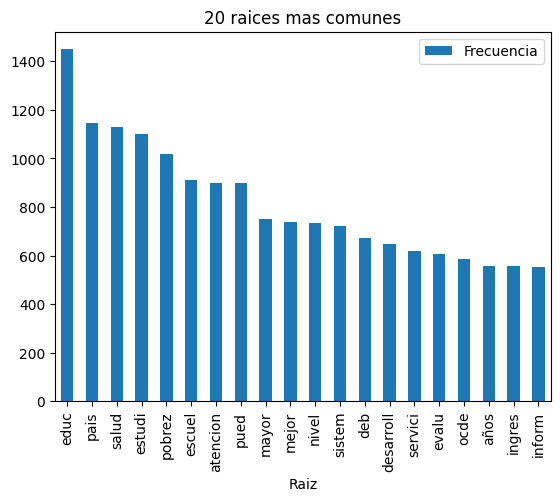

In [23]:
freq_df.plot.bar()
plt.title('20 raices mas comunes')

Como podemos ver, entre las 20 raizes mas comunes, se encuentran en el top 5 "educ", "salud" y "pobrez", que, precisamente, podemos asociar a la educación, salud, y pobreza, es decir, ODS 4, 3, y 1 respectivamente. Esto concuerda con el desbalance que vimos previamente en el perfilamiento de datos, habiendo mayor frecuencia en temas de educación (ODS 4).


 10 raices mas comunes del ODS 1



,Frecuencia
Raiz,
pobrez,1003
ingres,362
pais,350
pobr,310
niñ,237
tas,224
pued,211
social,209
mayor,204


Text(0.5, 1.0, '10 raices mas comunes del ODS 1')

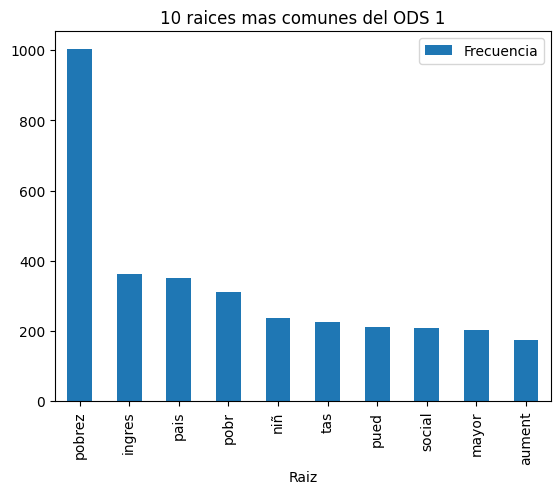

In [24]:
#Palabras/Stems mas comunes por categoría.
stem_1= [stems for stems_list in train_bd[train_bd["labels"]==1]["stem"] for stems in stems_list]
stem_3= [stems for stems_list in train_bd[train_bd["labels"]==3]["stem"] for stems in stems_list]
stem_4= [stems for stems_list in train_bd[train_bd["labels"]==4]["stem"] for stems in stems_list]

#Contadores por categoria:
c_1=Counter(stem_1)
c_3=Counter(stem_3)
c_4=Counter(stem_4)

top_1=c_1.most_common(10)
top_3=c_3.most_common(10)
top_4=c_4.most_common(10)

freq_df1 = pd.DataFrame(top_1, columns=['Raiz', 'Frecuencia'])
freq_df1.set_index("Raiz", inplace=True)
freq_df3 = pd.DataFrame(top_3, columns=['Raiz', 'Frecuencia'])
freq_df3.set_index("Raiz", inplace=True)
freq_df4 = pd.DataFrame(top_4, columns=['Raiz', 'Frecuencia'])
freq_df4.set_index("Raiz", inplace=True)


print("\n 10 raices mas comunes del ODS 1\n")
display(freq_df1)
freq_df1.plot.bar()
plt.title('10 raices mas comunes del ODS 1')


 10 raices mas comunes del ODS 3



,Frecuencia
Raiz,
salud,1078
atencion,820
servici,463
medic,456
pais,422
pacient,329
mental,322
sistem,307
mayor,299


Text(0.5, 1.0, '10 raices mas comunes del ODS 3')

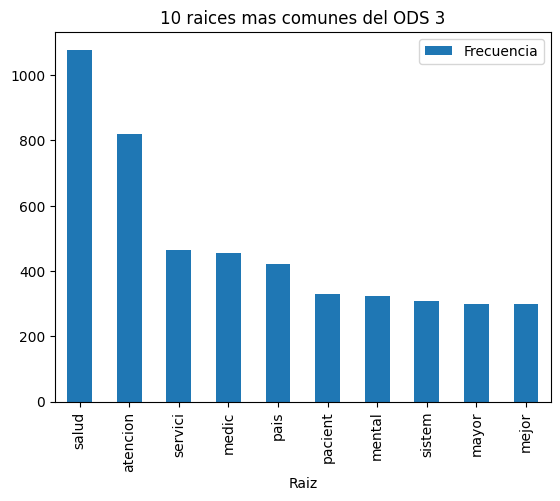

In [25]:
print("\n 10 raices mas comunes del ODS 3\n")
display(freq_df3)
freq_df3.plot.bar()
plt.title('10 raices mas comunes del ODS 3')


 10 raices mas comunes del ODS 4



,Frecuencia
Raiz,
educ,1303
estudi,976
escuel,889
evalu,495
docent,494
pued,404
aprendizaj,389
desarroll,387
mejor,379


Text(0.5, 1.0, '10 raices mas comunes del ODS 4')

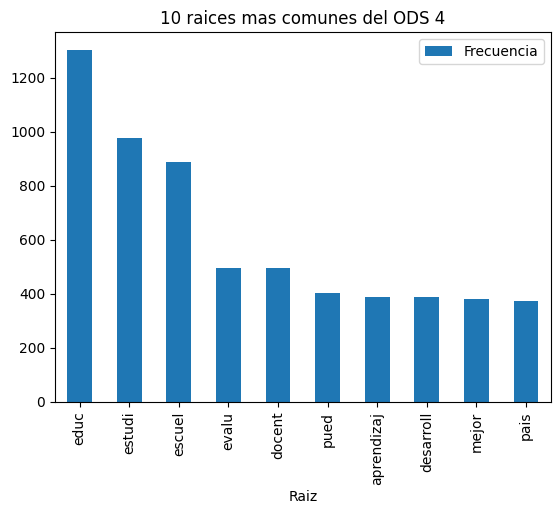

In [26]:
print("\n 10 raices mas comunes del ODS 4\n")
display(freq_df4)
freq_df4.plot.bar()
plt.title('10 raices mas comunes del ODS 4')

Ahora bien, reconocemos que mas de 8000 raices de palabras diferentes son demasiadas variables explicativas para un solo modelo, sin decir que muchas de estas palabras seguro se repetiran veces entre las categorías.

Con tal de simplificar nuevamente el modelo, a la vez que tomando la significancia de cada clase, armaremos un vocabulario a base de las palabras mas frecuentes de cada categoría, asegurando de evitar palabras repetidas. De manera arbitraria, y en función a otras cantidades probadas durante el proyecto, reduciremos entonces las palabras a alrededor de 100 palabras (50 por categoría que sin repeticiones se redujeron a 105).

In [27]:
#top 40
top_50_1=set([word[0] for word in c_1.most_common(50)])
top_50_3=set([word[0] for word in c_3.most_common(50)])
top_50_4=set([word[0] for word in c_4.most_common(50)])

diferentes=top_50_1.union(top_50_3, top_50_4)
len(diferentes)

105

#### Construcción Matriz TF_IDF:

Para terminar, construiremos la matriz TF-IDF que servira como el set de variables explicativas para nuestros modelos.

In [28]:
#Construccion:
from sklearn.feature_extraction.text import TfidfVectorizer
vocabulario = list(diferentes)
#Vectorizador
vector=TfidfVectorizer(vocabulary=vocabulario)
# Aplicar tf-idf sobre la columna original Description
tfidf_matrix_entren = vector.fit_transform(train_bd['stem'].str.join(" ").fillna(''))
tfidf_matrix_prueba = vector.fit_transform(val_bd['stem'].str.join(" ").fillna(''))

# Convertir matriz tf-idf en DataFrame
tfidf_df_entren = pd.DataFrame(tfidf_matrix_entren.toarray(), columns=vocabulario)
tfidf_df_prueba = pd.DataFrame(tfidf_matrix_prueba.toarray(), columns=vocabulario)

#Agregar las categorias
train_final=pd.concat([tfidf_df_entren, train_bd["labels"].to_frame()], axis=1)
val_final=tfidf_df_prueba
train_final.sample(10)

,vid,utiliz,habil,econom,general,reduc,atencion,docent,segur,calid,...,mayor,maestr,embarg,line,formacion,numer,nuev,pobr,primari,labels
1871,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.097817,0.0,0.000000,0.0,0.570221,0.000000,0.127709,0.000000,0.131582,4
375,0.0,0.000000,0.0,0.000000,0.000000,0.648268,0.0,0.0,0.0,0.284002,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3
2125,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1
1505,0.0,0.178390,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.092102,0.000000,1
637,0.0,0.261726,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4
2248,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.481143,0.000000,0.000000,0.000000,0.000000,4
1817,0.0,0.145796,0.0,0.155420,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1
160,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.164478,0.000000,1
1461,0.0,0.000000,0.0,0.445744,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.310841,0.0,0.186834,0.0,0.000000,0.425045,0.000000,0.215885,0.000000,1
605,0.0,0.510770,0.0,0.000000,0.237176,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4


Adicionalmente, recordemos que existía un desbalance de registros por categoría:

In [29]:
texto_label=train_final.groupby('labels')[vocabulario[0]].count()
display(texto_label)

,vid
labels,
1,505
3,894
4,1025


Para evitar sesgos por ello en nuestro modelos, aplicaremos el método de oversampling SMOTE mas adelante para evitar sesgos durante los entrenamientos de cada modelo.

## Seccion 3: Construcción y evaluacion de modelos

### Division de entrenamiento y Validacion

Con tal de tener datos de entrenamiento y validación previo al uso de las pruebas, dividiremos nuestros datos de entrenamiento en subconjuntos de entrenamiento y validación para verificar el rendimiento del modelo de arboles a continuación. Adicionalmente, para evitar sesgo en modelo alguno, aplicaremos el método SMOTE sobre los datos de entrenamiento, tal que tengamos igual número de registros de cada categoría mediante registros sintéticos

Por su parte, los datos no etiquetados de los datos de prueba serviran como el test final, con el cual se obtendran las predicciones finales.

Las salidas de este paso son:
- `X_train_bal`, `y_train_bal`: entrenamiento balanceado.  
- `X_val`, `y_val`: validación sin balancear.  
- `X_test`: conjunto sin etiquetas.

In [30]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Dividimos los datos del dataframe
X_train, X_val, Y_train, Y_val = train_test_split(train_final[vocabulario[:100]], train_final["labels"], test_size=0.2, random_state=0)

#Balanceamos los datos de entrenamiento mediante SMOTE con un estado de aleatoriedad fijo para tener siempre
#los mismos registros sinteticos
smote=SMOTE(sampling_strategy='not majority', random_state=0)
X_train_bal, Y_train_bal = smote.fit_resample(X_train, Y_train)
#Test directamente con los datos dados:
X_test=val_final


In [31]:
X_train_bal.shape[0]

2436

Adicionalmente, para mayor seguridad en nuestros resultados, haremos uso del GridSearchCv para probar diferentes hiperparámetros, con tal de encontrar aquel que priorize un mejor F1-Score, que es el objetivo que tenemos para los modelos. Haremos esta búsqueda con hasta 20 particiones, siendo que numeros mayores representaron demoras considerables en la extracción de los hiperparámetros.

### Modelo con Arboles de Decisión (Nicolas Ballen)

Un algoritmo de clasificación con árbol de decisión divide recursivamente los datos haciendo en base a comparaciones de sus variables de decisión para formar subgrupos cada vez más homogéneos (cada vez siendo mas de la misma categoría) y terminar en hojas que asignan una clase. En cada paso elige la mejor partición según una métrica de impureza (por ejemplo, Gini o entropía). Para implementarlo, usaremos la implementacion DecisionTreeClassifier de sklearn.

#### Paso 1-Construcción inicial del modelo

In [32]:
#Construccion del modelo de arboles
from sklearn.tree import DecisionTreeClassifier
arbol = DecisionTreeClassifier(random_state=0)

#### Paso 2-Definicion de Hiperparametros

Para el caso de los arboles de decisión, tenemos 3 hiperparametros para considerar:

* **Criterio**: Bajo que criterio se valorarán los datos de una variable (entropía o coeficiente de gini)
* **Profundidad maxima**: Que tan bajo se dividirá el árbol. Dado que decidimos tratar con un vocabulario tan grande que dividiría el arbol indefinidamente, haciendolo absurdamente pesado, asumiremos una profundidad maxima de hasta 20 niveles, es decir, 2 a la 20 (es decir casí una MB asumiendo que cada nodo fuera de 1 byte). Esto de igual forma probando profundidades menores con tal de evitar el overfitting.
* **Muestra mínima para separación**: Mínimo de una muestra necesario para poder dividir el nodo padre a otros dos hijos. Por defecto asumimos 2 como suficiente. Sin embargo, como ello resultaría en divisiones constantes hasta hojas de 1 registro (overfit), probaremos también con valores mayores que no dividan tanto los 2436 registros (balanceados).


In [33]:
#criterios
criterios=["entropy", "gini"]
#profundidades
profundidades=[2,4,6,8,20]
minimos=[2, 4, 8, 16]

params={"criterion":criterios, "max_depth":profundidades, "min_samples_split":minimos}

#### Paso 3- Validación cruzada para el mejor modelo:


Para terminar, haremos una validación cruzada para probar todos los hiperparametros, y con ello definir el mejor modelo a nuestro alcance:

In [34]:
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

#Particiones
particiones=KFold(n_splits=20, shuffle=True, random_state = 0)
#Grid search priorizando f1 score
mejor_arbol=GridSearchCV(arbol, params, scoring="f1_macro", cv=particiones)
# Ajuste del modelo
mejor=mejor_arbol.fit(X_train_bal, Y_train_bal)
mejor_arbol.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}

#### Paso 4 Revision de Resultados

Métricas de validacion
              precision    recall  f1-score   support

           1       0.88      0.86      0.87        98
           3       0.88      0.91      0.90       174
           4       0.94      0.92      0.93       213

    accuracy                           0.91       485
   macro avg       0.90      0.90      0.90       485
weighted avg       0.91      0.91      0.91       485



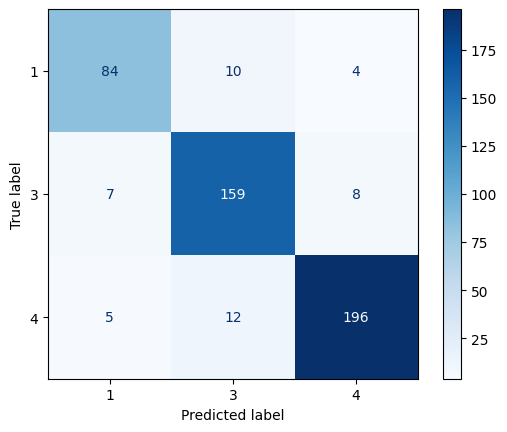

In [35]:
#Revision de métricas
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
predicciones=mejor_arbol.predict(X_val)
reporte=classification_report(Y_val, predicciones)
print("Métricas de validacion")
print(reporte)
cm = confusion_matrix(Y_val, predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,3,4])
disp.plot(cmap=plt.cm.Blues)

plt.show()

Métricas de entrenamiento
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       812
           3       0.97      1.00      0.98       812
           4       1.00      0.99      0.99       812

    accuracy                           0.99      2436
   macro avg       0.99      0.99      0.99      2436
weighted avg       0.99      0.99      0.99      2436



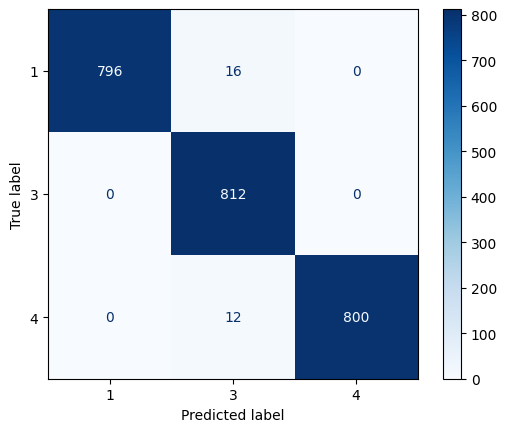

In [36]:
predicciones=mejor_arbol.predict(X_train_bal)
reporte=classification_report(Y_train_bal, predicciones)
print("Métricas de entrenamiento")
print(reporte)
cm = confusion_matrix(Y_train_bal, predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,3,4])
disp.plot(cmap=plt.cm.Blues)

Como podemos ver, para un primer modelo, el algoritmo de árboles de decisión arrojo buenos resultados, obteniendo un f1_score promedio de 98% en los datos de entrenamiento, y 91% en los datos de validación.

### Modelo con KNN (Vecinos cercanos) (Carlos Poveda)

Primero normalizamos para que todas las variables aporten por igual a la distancia

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)


labels_sorted = sorted(np.unique(Y_train_bal))
target_names  = [str(x) for x in labels_sorted]

def evaluar_knn(pipeline, X_train, y_train, X_test, y_test, titulo="KNN"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Probabilidades
    y_proba = None
    try:
        y_proba = pipeline.predict_proba(X_test)
    except Exception:
        pass

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {titulo} ===")
    print("Accuracy (test):", round(acc, 4))

    # AUC
    if y_proba is not None:
        clases_unicas = np.unique(y_test)
        if len(clases_unicas) == 2:

            clase_pos = clases_unicas.max()
            idx_pos = list(pipeline.classes_).index(clase_pos)
            auc = roc_auc_score(y_test, y_proba[:, idx_pos])
            print("ROC AUC (test):", round(auc, 4))
        else:

            auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
            print("ROC AUC macro-OVR (test):", round(auc, 4))

    print("\nReporte de clasificación:")
    print(classification_report(
        y_test, y_pred,
        labels=labels_sorted,
        target_names=target_names
    ))

    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, colorbar=False)
    plt.title(f"Matriz de confusión — {titulo}")
    plt.show()

    if (y_proba is not None) and (len(np.unique(y_test)) == 2):
        clase_pos = np.unique(y_test).max()
        idx_pos = list(pipeline.classes_).index(clase_pos)
        RocCurveDisplay.from_predictions(y_test, y_proba[:, idx_pos])
        plt.title(f"Curva ROC — {titulo}")
        plt.show()



=== KNN Default (k=5, Euclídea) ===
Accuracy (test): 0.9216
ROC AUC macro-OVR (test): 0.9786

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.82      0.94      0.88        98
           3       0.92      0.93      0.92       174
           4       0.98      0.91      0.94       213

    accuracy                           0.92       485
   macro avg       0.91      0.92      0.91       485
weighted avg       0.93      0.92      0.92       485



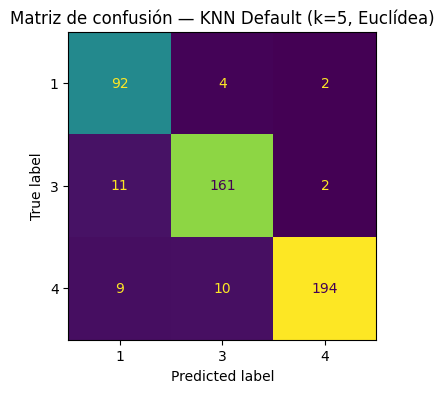

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_default = Pipeline([
    ("norm", Normalizer(norm ='l2')),
    ("knn", KNeighborsClassifier())
])
evaluar_knn(pipe_default, X_train_bal, Y_train_bal, X_val, Y_val, titulo="KNN Default (k=5, Euclídea)")


=== KNN Distancia Euclídea (p=2) ===
Accuracy (test): 0.8619
ROC AUC macro-OVR (test): 0.9626

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.64      0.96      0.77        98
           3       0.94      0.82      0.87       174
           4       0.97      0.85      0.91       213

    accuracy                           0.86       485
   macro avg       0.85      0.88      0.85       485
weighted avg       0.89      0.86      0.87       485



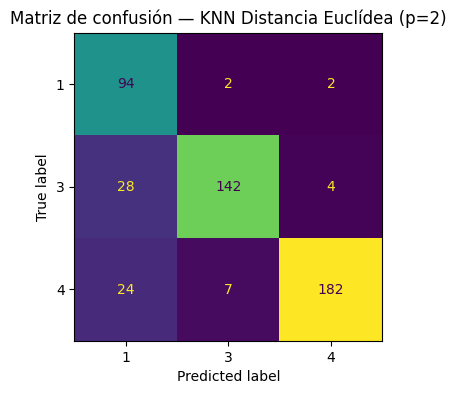

In [39]:
pipe_euclid = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(metric="minkowski", p=2))])
pipe_manhat = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(metric="minkowski", p=1))])

evaluar_knn(pipe_euclid, X_train_bal, Y_train_bal, X_val, Y_val, titulo="KNN Distancia Euclídea (p=2)")



=== KNN Distancia Manhattan (p=1) ===
Accuracy (test): 0.8804
ROC AUC macro-OVR (test): 0.9747

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.73      0.92      0.81        98
           3       0.89      0.86      0.88       174
           4       0.96      0.88      0.92       213

    accuracy                           0.88       485
   macro avg       0.86      0.89      0.87       485
weighted avg       0.89      0.88      0.88       485



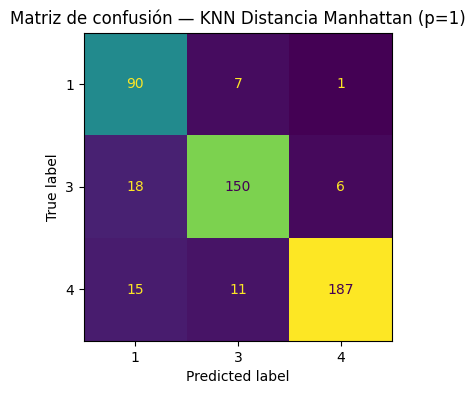

In [40]:

evaluar_knn(pipe_manhat, X_train_bal, Y_train_bal, X_val, Y_val, titulo="KNN Distancia Manhattan (p=1)")

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_euclid = cross_val_score(
    pipe_euclid, X_train_bal, Y_train_bal, cv=cv, scoring='f1_macro'
)
scores_manhat = cross_val_score(
    pipe_manhat, X_train_bal, Y_train_bal, cv=cv, scoring='f1_macro'
)

print("CV f1_macro AUC (Euclídea): ", scores_euclid.round(4), "-> media:", round(scores_euclid.mean(), 4))
print("CV f1_macro AUC (Manhattan):", scores_manhat.round(4), "-> media:", round(scores_manhat.mean(), 4))

CV f1_macro AUC (Euclídea):  [0.8821 0.8779 0.8332 0.8631 0.8375] -> media: 0.8588
CV f1_macro AUC (Manhattan): [0.91   0.9098 0.8853 0.8874 0.8738] -> media: 0.8933



=== KNN k=1 (muy flexible, riesgo de sobreajuste) ===
Accuracy (test): 0.868
ROC AUC macro-OVR (test): 0.908

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.71      0.94      0.81        98
           3       0.92      0.84      0.88       174
           4       0.93      0.86      0.89       213

    accuracy                           0.87       485
   macro avg       0.85      0.88      0.86       485
weighted avg       0.88      0.87      0.87       485



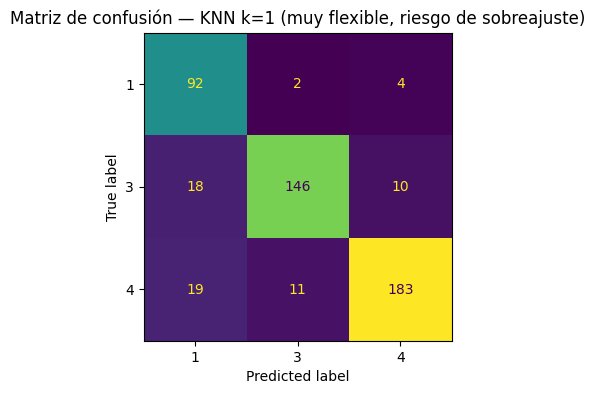

In [42]:
pipe_k_small = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=1))])
evaluar_knn(pipe_k_small, X_train_bal, Y_train_bal, X_val, Y_val, titulo="KNN k=1 (muy flexible, riesgo de sobreajuste)")


=== KNN k=31 (suaviza, posible subajuste) ===
Accuracy (test): 0.8495
ROC AUC macro-OVR (test): 0.9807

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.61      0.98      0.75        98
           3       0.97      0.79      0.87       174
           4       0.96      0.84      0.89       213

    accuracy                           0.85       485
   macro avg       0.85      0.87      0.84       485
weighted avg       0.89      0.85      0.86       485



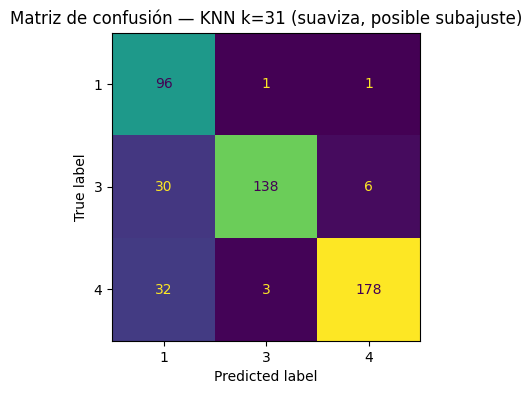

In [43]:
pipe_k_large = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=31))])
evaluar_knn(pipe_k_large, X_train_bal, Y_train_bal, X_val, Y_val, titulo="KNN k=31 (suaviza, posible subajuste)")

Mejores hiperparámetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
Mejor score de CV (F1-macro, train): 0.921

=== Mejor modelo (GridSearch) ===
Accuracy (test): 0.9052
ROC AUC macro-OVR (test): 0.9868

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.78      0.95      0.86        98
           3       0.94      0.86      0.89       174
           4       0.95      0.92      0.94       213

    accuracy                           0.91       485
   macro avg       0.89      0.91      0.90       485
weighted avg       0.91      0.91      0.91       485



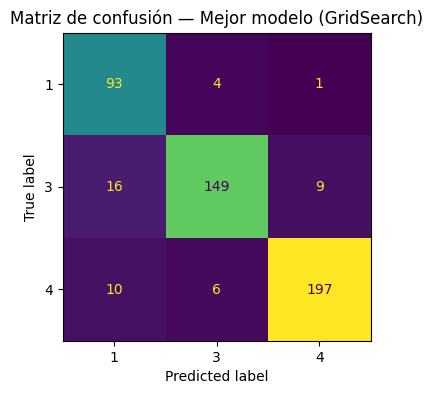

In [44]:

pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2],
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

grid.fit(X_train_bal, Y_train_bal)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de CV (F1-macro, train):", round(grid.best_score_, 4))

best_knn = grid.best_estimator_
evaluar_knn(best_knn, X_train_bal, Y_train_bal, X_val, Y_val, titulo="Mejor modelo (GridSearch)")


### Modelo con Bayes Ingenuos (Camilo Sanchez)

#### Paso 1 — División de train/validation y preparación de conjuntos

En este paso se crea un conjunto de validación a partir de la matriz TF-IDF de entrenamiento (`tfidf_df_entren`) y de las etiquetas correspondientes (`train_bd['labels']`).  
El objetivo es contar con datos independientes para comparar modelos y calcular el **F1-score**, evitando usar el archivo de prueba que no incluye etiquetas.

Se realiza un split estratificado (80/20) para mantener la proporción de clases.  
Posteriormente, se aplica **SMOTE** únicamente sobre el subconjunto de entrenamiento, con el fin de balancear las clases minoritarias.  
El archivo `tfidf_df_prueba` se conserva como `X_test`, ya que será utilizado únicamente al final para generar las predicciones definitivas.

Las salidas de este paso son:
- `X_train_bal`, `y_train_bal`: entrenamiento balanceado.  
- `X_val`, `y_val`: validación sin balancear.  
- `X_test`: conjunto sin etiquetas.


In [45]:

import pandas as pd

# Alinear TF-IDF de train con las etiquetas sin recalcular nada
# (si hay filas sin etiqueta, se descartan solo para la validación interna)
aligned = pd.concat(
    [tfidf_df_entren.reset_index(drop=True),
     train_bd['labels'].reset_index(drop=True)],
    axis=1
).dropna(subset=['labels'])

X_all = aligned.drop(columns=['labels'])
y_all = aligned['labels'].astype(int).values  # ajusta el dtype si tus labels no son enteros

# Split estratificado 80/20
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# SMOTE solo en train
X_tr = X_tr.fillna(0).astype(float)
X_val = X_val.fillna(0).astype(float)
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_tr, y_tr)

# X_test: se mantiene para la entrega final (sin labels)
X_test = tfidf_df_prueba.reindex(columns=list(X_all.columns), fill_value=0).values

print("Shapes -> X_train_bal:", X_train_bal.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)
print("Clases (train_bal):")
print(pd.Series(y_train_bal).value_counts())
print("Clases (val):")
print(pd.Series(y_val).value_counts())





Shapes -> X_train_bal: (2460, 105) | X_val: (485, 105) | X_test: (152, 105)
Clases (train_bal):
3    820
1    820
4    820
Name: count, dtype: int64
Clases (val):
4    205
3    179
1    101
Name: count, dtype: int64


#### Paso 2 — Naive Bayes Multinomial: entrenamiento y evaluación en *validation*

Se entrena **MultinomialNB** con `X_train_bal` y `y_train_bal`.  
La evaluación se realiza sobre `X_val` y `y_val` usando **F1-macro** y **F1-weighted**, junto con la matriz de confusión y el *classification report*.  


In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Entrenamiento
mnb = MultinomialNB()
mnb.fit(X_train_bal, y_train_bal)

# Predicción en validation
y_val_pred = mnb.predict(np.asarray(X_val))

# Métricas
f1_macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

print("=== MultinomialNB (validation) ===")
print(f"F1-macro:    {f1_macro:.4f}")
print(f"F1-weighted: {f1_weighted:.4f}")

# Matriz de confusión
labels_sorted = sorted(pd.Series(y_val).unique())
cm = confusion_matrix(y_val, y_val_pred, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels_sorted],
                        columns=[f"pred_{l}" for l in labels_sorted])

print("\nMatriz de confusión:")
display(cm_df)

# Classification report como DataFrame
report_dict = classification_report(y_val, y_val_pred, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df)


=== MultinomialNB (validation) ===
F1-macro:    0.9283
F1-weighted: 0.9346

Matriz de confusión:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


,pred_1,pred_3,pred_4
true_1,96,4,1
true_3,9,165,5
true_4,8,5,192


,precision,recall,f1-score,support
1,0.849558,0.950495,0.897196,101.000000
3,0.948276,0.921788,0.934844,179.000000
4,0.969697,0.936585,0.952854,205.000000
accuracy,0.934021,0.934021,0.934021,0.934021
macro avg,0.922510,0.936289,0.928298,485.000000
weighted avg,0.936772,0.934021,0.934616,485.000000


#### Paso 3 — Naive Bayes Complement: entrenamiento y evaluación en *validation*

En este paso se entrena **ComplementNB**, una variante de Naive Bayes diseñada para mejorar el desempeño en escenarios con clases desbalanceadas.  
El entrenamiento se realiza con `X_train_bal` y `y_train_bal`, y la evaluación con `X_val` y `y_val`.  

Se calculan las métricas **F1-macro** y **F1-weighted**, además de la matriz de confusión y el *classification report*, con el fin de compararlo contra los resultados obtenidos en el Paso 2 con MultinomialNB.


In [47]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Entrenamiento
cnb = ComplementNB()
cnb.fit(X_train_bal, y_train_bal)

# Predicción en validation
y_val_pred_cnb = cnb.predict(np.asarray(X_val))

# Métricas
f1_macro_cnb = f1_score(y_val, y_val_pred_cnb, average='macro', zero_division=0)
f1_weighted_cnb = f1_score(y_val, y_val_pred_cnb, average='weighted', zero_division=0)

print("=== ComplementNB (validation) ===")
print(f"F1-macro:    {f1_macro_cnb:.4f}")
print(f"F1-weighted: {f1_weighted_cnb:.4f}")

# Matriz de confusión
labels_sorted = sorted(pd.Series(y_val).unique())
cm_cnb = confusion_matrix(y_val, y_val_pred_cnb, labels=labels_sorted)
cm_cnb_df = pd.DataFrame(cm_cnb, index=[f"true_{l}" for l in labels_sorted],
                           columns=[f"pred_{l}" for l in labels_sorted])

print("\nMatriz de confusión:")
display(cm_cnb_df)

# Classification report como DataFrame
report_dict_cnb = classification_report(y_val, y_val_pred_cnb, zero_division=0, output_dict=True)
report_df_cnb = pd.DataFrame(report_dict_cnb).transpose()
display(report_df_cnb)


=== ComplementNB (validation) ===
F1-macro:    0.9289
F1-weighted: 0.9345

Matriz de confusión:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ComplementNB was fitted with feature names
  warnings.warn(


,pred_1,pred_3,pred_4
true_1,97,3,1
true_3,10,163,6
true_4,7,5,193


,precision,recall,f1-score,support
1,0.850877,0.960396,0.902326,101.000000
3,0.953216,0.910615,0.931429,179.000000
4,0.965000,0.941463,0.953086,205.000000
accuracy,0.934021,0.934021,0.934021,0.934021
macro avg,0.923031,0.937491,0.928947,485.000000
weighted avg,0.936885,0.934021,0.934522,485.000000


#### Paso 4 — Comparación de variantes de Naive Bayes

Se comparan las métricas obtenidas en validación para las dos variantes de Naive Bayes probadas:

- **MultinomialNB**  
- **ComplementNB**  

Esto permite observar cuál de los dos enfoques resulta más adecuado en el contexto del proyecto.


In [48]:
# Paso 4: tabla comparativa de Naive Bayes

resultados_nb = pd.DataFrame([
    {"Modelo": "MultinomialNB", "F1_macro": f1_macro, "F1_weighted": f1_weighted},
    {"Modelo": "ComplementNB",  "F1_macro": f1_macro_cnb, "F1_weighted": f1_weighted_cnb}
])

display(resultados_nb)


,Modelo,F1_macro,F1_weighted
0,MultinomialNB,0.928298,0.934616
1,ComplementNB,0.928947,0.934522


**texto en negrita**## Seccion 4: Revision de Resultados

Tras haber probado con múltiples algortimos de clasificacion, terminamos con 3 modelos con f1-scores macros definidos a continuacion:

In [49]:
#Tabla de puntajes
puntajes={
    "algoritmos":["ArbolDecision", "KNN", "Bayes-NB Multinomial"],
    "F1-Promedio de Validacion":[0.91, 0.]
}

## Seccion 5: Modelo Elegido

### PASO 1 — Generar predicciones finales con MultinomialNB

Entrenamos el modelo en todo el conjunto de entrenamiento (train_final) y generamos las predicciones para el conjunto de validación/prueba (val_final).

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Definir X e y
feature_cols = [c for c in train_final.columns if c != "labels"]

X_train = train_final[feature_cols].fillna(0).values
y_train = train_final["labels"].astype(int).values

X_val = val_final.reindex(columns=feature_cols, fill_value=0).values

# Entrenar modelo final MultinomialNB
from sklearn.naive_bayes import MultinomialNB

final_nb = MultinomialNB(alpha=1.0)
final_nb.fit(X_train, y_train)

# Predicciones en validación
y_val_pred_final = final_nb.predict(X_val)



### PASO 2 — Anexar las predicciones al DataFrame de validación

Creamos una copia de val_final y le agregamos la columna pred_label con la clase asignada por MultinomialNB.

In [52]:
# Paso 2: añadir columna con predicciones
val_submit = val_final.copy()
val_submit["pred_label"] = y_val_pred_final

val_submit.head()


,vid,utiliz,habil,econom,general,reduc,atencion,docent,segur,calid,...,mayor,maestr,embarg,line,formacion,numer,nuev,pobr,primari,pred_label
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.347395,0.0,0.0,...,0.205656,0.0,0.254805,0.0,0.0,0.0,0.0,0.0,0.000000,4
1,0.0,0.420653,0.0,0.0,0.343466,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.175621,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.174334,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.233141,4


PASO 3 — Exportar archivo para la entrega

Guardamos el resultado en Excel (o CSV) con la columna de predicciones incluidas.


In [53]:
# Paso 3: exportar predicciones a Excel
val_submit.to_excel("predicciones_multinomialNB.xlsx", index=False)


### PASO 4 — Construir el archivo de entrega limpio (val_bd + predicciones)

In [56]:
# Paso 4: archivo de entrega con columnas originales + pred_label (y opcional pred_conf)

# 1) Partimos del dataframe ORIGINAL de validación/prueba:
submit = val_bd.copy()

# 2) Añadimos la predicción del modelo final (MultinomialNB):
submit["pred_label"] = y_val_pred_final

submit["pred_conf"]  = final_nb.predict_proba(X_val).max(axis=1)

# 3) Exportamos:
submit.to_excel("predicciones_multinomialNB.xlsx", index=False)
